# SimNet Training for Balancing Robot

This notebook trains a SimNet model using both physics simulation data and real-world data.

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
import glob
from matplotlib import pyplot as plt

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

## Load Configuration

In [2]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

## Initialize Models and Environment

In [3]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Collect and Process Physics Data

In [4]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 95200 training samples
Collected 23800 validation samples


## Train on Physics Data

In [5]:
# Train on physics data
physics_history = trainer.train(
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/100 - Train Loss: 5.519701 - Val Loss: 3.193862
Epoch 2/100 - Train Loss: 2.341861 - Val Loss: 1.683409
Epoch 3/100 - Train Loss: 1.278015 - Val Loss: 0.914353
Epoch 4/100 - Train Loss: 0.688552 - Val Loss: 0.500562
Epoch 5/100 - Train Loss: 0.387086 - Val Loss: 0.293073
Epoch 6/100 - Train Loss: 0.233961 - Val Loss: 0.184923
Epoch 7/100 - Train Loss: 0.151467 - Val Loss: 0.123735
Epoch 8/100 - Train Loss: 0.103995 - Val Loss: 0.087328
Epoch 9/100 - Train Loss: 0.075333 - Val Loss: 0.064315
Epoch 10/100 - Train Loss: 0.056867 - Val Loss: 0.048968
Epoch 11/100 - Train Loss: 0.044566 - Val Loss: 0.038520
Epoch 12/100 - Train Loss: 0.035806 - Val Loss: 0.031115
Epoch 13/100 - Train Loss: 0.029542 - Val Loss: 0.025807
Epoch 14/100 - Train Loss: 0.024845 - Val Loss: 0.021754
Epoch 15/100 - Train Loss: 0.021235 - Val Loss: 0.018594
Epoch 16/100 - Train Loss: 0.018447 - Val Loss: 0.016188
Epoch 17/100 - Train Loss: 0.016228 - Val Loss: 0.014217
Epoch 18/100 - Train Loss: 0.014429 - Va

In [6]:
# Save physics trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_physics_final.pt')

simnet_physics = SimNet(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    hidden_dims=simnet_config['model']['hidden_dims']
)
simnet_physics.load_state_dict(torch.load(log_dir / 'simnet_physics_final.pt')['state_dict'])

<All keys matched successfully>

## Load and Process Real-World Data

In [7]:
# Find all files that start with robot_logs and end with .json
log_files = glob.glob('../data/robot_logs*.json')
print(f"Found {len(log_files)} log files: {log_files}")

# Initialize empty list to store all episodes
all_episodes = []

# Load and append data from each file
for log_file in log_files:
    with open(log_file, 'r') as f:
        log_data = json.load(f)
        # Append episodes from this file
        all_episodes.extend(log_data['episodes'])
        print(f"Loaded {len(log_data['episodes'])} episodes from {log_file}")

# Process combined data
real_train_data, real_val_data = trainer.process_real_data(all_episodes)
print(f"Processed {len(real_train_data['states'])} real training samples")
print(f"Processed {len(real_val_data['states'])} real validation samples")

Found 2 log files: ['../data\\robot_logs_20250308_205032_no_motor.json', '../data\\robot_logs_20250308_205436_with_motor.json']
Loaded 40 episodes from ../data\robot_logs_20250308_205032_no_motor.json
Loaded 14 episodes from ../data\robot_logs_20250308_205436_with_motor.json
Processed 3265 real training samples
Processed 816 real validation samples


## Fine-tune on Real Data

In [8]:
# Fine-tune on real data
real_history = trainer.train(
    train_data=real_train_data,
    val_data=real_val_data,
    is_finetuning=True,
    log_dir=log_dir / 'real'
)

Epoch 1/20 - Train Loss: 1.687263 - Val Loss: 1.474004
Epoch 2/20 - Train Loss: 1.488732 - Val Loss: 1.451885
Epoch 3/20 - Train Loss: 1.468792 - Val Loss: 1.438121
Epoch 4/20 - Train Loss: 1.459349 - Val Loss: 1.428643
Epoch 00105: reducing learning rate of group 0 to 2.5000e-04.
Epoch 5/20 - Train Loss: 1.451751 - Val Loss: 1.420099
Epoch 6/20 - Train Loss: 1.445512 - Val Loss: 1.415363
Epoch 7/20 - Train Loss: 1.442019 - Val Loss: 1.411459
Epoch 8/20 - Train Loss: 1.438674 - Val Loss: 1.407495
Epoch 9/20 - Train Loss: 1.435339 - Val Loss: 1.403700
Epoch 00110: reducing learning rate of group 0 to 1.2500e-04.
Epoch 10/20 - Train Loss: 1.431983 - Val Loss: 1.399804
Epoch 11/20 - Train Loss: 1.429202 - Val Loss: 1.397839
Epoch 12/20 - Train Loss: 1.427578 - Val Loss: 1.396044
Epoch 13/20 - Train Loss: 1.425998 - Val Loss: 1.394326
Epoch 14/20 - Train Loss: 1.424450 - Val Loss: 1.392562
Epoch 00115: reducing learning rate of group 0 to 6.2500e-05.
Epoch 15/20 - Train Loss: 1.422930 - Va

## Analyze Predictions

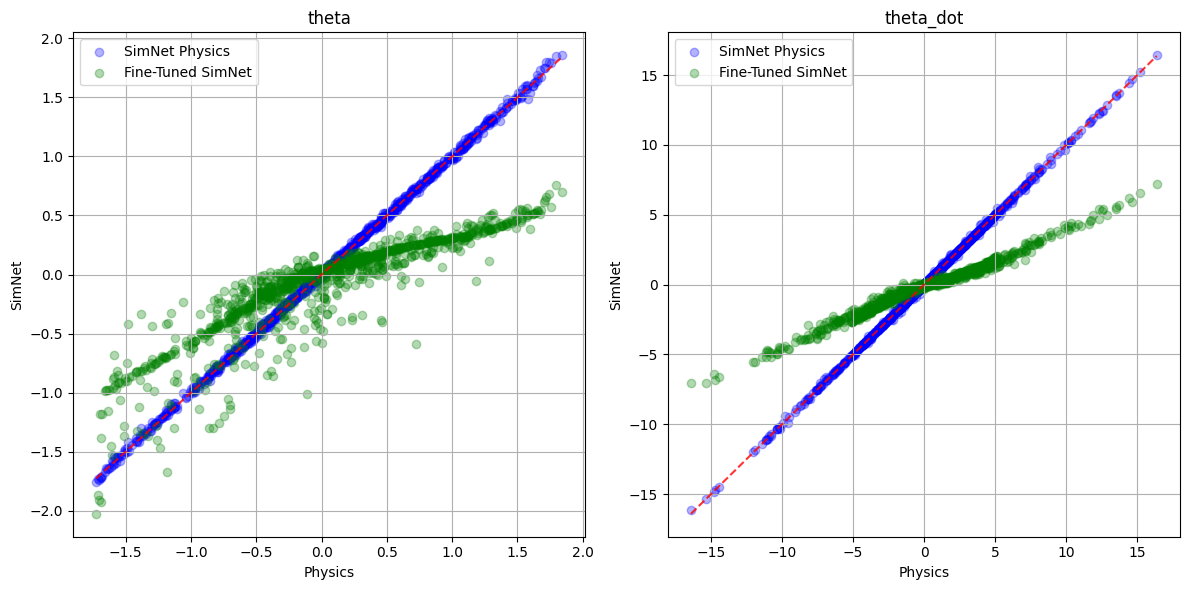

In [ ]:

test_states = val_data["states"][:1000]
test_actions = val_data["actions"][:1000]
physics_preds = val_data["next_states"][:1000]  # The actual next states from the physics data

# Get SimNet predictions
simnet_preds = []
simnet_physics_preds = []
for s, a in zip(test_states, test_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    simnet_preds.append(pred_next)
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    simnet_physics_preds.append(pred_next_physics)
simnet_preds = np.array(simnet_preds)
simnet_physics_preds = np.array(simnet_physics_preds)

# Plot comparison (assuming your plot function looks something like this)
fig = plot_predictions_comparison(
    physics_preds=physics_preds,   # ground-truth next states
    simnet_preds=simnet_preds,     # network-predicted next states
    simnet_physics_preds=simnet_physics_preds,  # network-predicted next states using simnet physics model
    save_path=log_dir / "prediction_comparison.png"
)
plt.show()


## Save Final Model

In [10]:
# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'real_history': real_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')
